In [128]:
import pandas as pd
import numpy as np
import json
import time
import os

def labelIPAddresses(row):
    if row['rule.sidid'] in ['external-access', 'inbound-access']:
        standardValues = ['169.254.169.254']
        if row['auditd.summary.object.primary'] in standardValues:
            pass
        elif row['auditd.summary.object.primary'].startswith('127.'):
            row['auditd.summary.object.primary'] = '(lopIP)'
        # rude filter for private ranges
        elif any([row['auditd.summary.object.primary'].startswith(x) for x in ['192.168.', '10.', '172.1', '172.2']]):
            row['auditd.summary.object.primary'] = '(prvIP)'
        else:
            row['auditd.summary.object.primary'] = '(pubIP)'
    return row


def preprocessAuditdTable(df,
    cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ],
    sids = [
    'execution',
    'mount',
    'external-access',
    'log-modification',
    'user_start',
    'user_end',
    'bind-access',
    'time-change',
    'perm_modification',
    'inbound-access',
    'unsucces_file_access'
    ]
):
    """
    input is a dataframe with 5min of data
    output is a string with data in fastText format
    """
    checks = []
    # filter only necessary event types and columns
    newdf = df[df['rule.sidid'].isin(sids)][cols].copy()
    del df

    checks.append(time.time())
    # dealing with NaN to avoid errors
    newdf.fillna("(none)", inplace=True)

    checks.append(time.time())
    ## ppid preprocessing
    newdf['process.ppid'] = newdf['process.ppid'].apply(lambda x: x if x == "1" else "(pid)")

    checks.append(time.time())
    # timestamping
    newdf['TimeStamp'] = pd.to_datetime(newdf.TimeStamp)
    newdf.sort_values(by=['TimeStamp'], inplace=True)

    checks.append(time.time())
    newdf = newdf.apply(labelIPAddresses, axis=1)

    checks.append(time.time())
    out = []
    for _, groupDf in newdf.groupby('hostname'):
    
        # adds this as last column
        groupDf['event.separator'] = "(sep)"

        # CONSIDER:
        # my data has been already divided to 5min chunks
        # it might be needed to do chunking here based on TimeStamp if not done

        arr = groupDf.drop(['TimeStamp', 'hostname'], axis=1).values

        # fastText expects whitespace separated values in utf-8
        # can't use spaces since are present in process.title, so use \t
        host_telemetry = ", ".join(arr.flatten()).encode().decode('utf-8', 'ignore') 
        out.append(host_telemetry)
    checks.append(time.time())

    return out, checks



In [129]:
FOLDER = "../../data/auditd_raw/"
LIMIT = 10
files = os.listdir(FOLDER)[:LIMIT]

global_checks = []
for i,file in enumerate(files):
    c1 = time.time()
    data = json.load(open(FOLDER+file, "r"))[:-1]
    c2 = time.time()
    ldf = pd.json_normalize(data)
    c3 = time.time()
    
    out, checks = preprocessAuditdTable(ldf)
    
    global_checks.append([c1,c2,c3] + checks)
    print(f"{i}, took: {time.time()-c1:.2f}s", end="; ")

0, took: 4.69s; 1, took: 5.00s; 2, took: 5.46s; 3, took: 4.63s; 4, took: 5.23s; 5, took: 4.80s; 6, took: 5.01s; 7, took: 4.54s; 8, took: 5.19s; 9, took: 4.68s; 

Text(0.5, 1.0, 'Average time per step over 10 iterations')

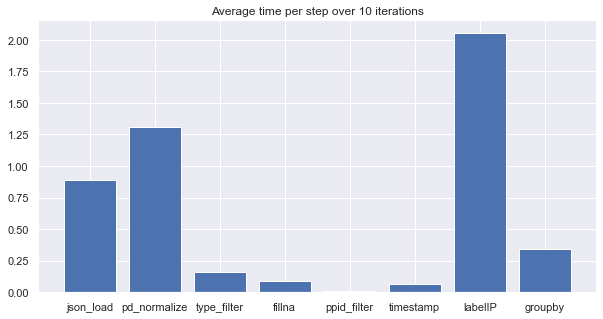

In [130]:
avg_ticks = np.diff(np.array(global_checks), axis=1).mean(axis=0)

# barplot avg_ticks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5))
steps = ['json_load', 'pd_normalize', 'type_filter', 'fillna', 'ppid_filter', 'timestamp', 'labelIP', 'groupby']
ax = plt.bar(x=steps, height=avg_ticks)
plt.title(f"Average time per step over {LIMIT} iterations")

In [131]:
out[0]

'execution, execve, unset, root, /usr/bin/runc, (none), /usr/bin/runc --root /run/containerd/runc/k8s.io --log /run/containerd/io.containerd.runtime.v2.task/k8s.io/eca644e99e4302eef32e, /run/containerd/io.containerd.runtime.v2.task/k8s.io/b592b9cb56c6d4992b395ede54c3758cd916af18c4e11f8c71c1d91b25d6b4f1, (pid), (none), (none), (sep), execution, execve, unset, root, /proc/self/exe, (none), /usr/bin/runc init, /run/containerd/io.containerd.runtime.v2.task/k8s.io/eca644e99e4302eef32e8ac7124500a89cd9fcbee80f41cc5472fabefd5ae0a3/rootfs, (pid), (none), (none), (sep), mount, mount, unset, root, /run/containerd/runc/k8s.io/eca644e99e4302eef32e8ac7124500a89cd9fcbee80f41cc5472fabefd5ae0a3/runc.xfF9jF, (none), /usr/bin/runc init, /run/containerd/io.containerd.runtime.v2.task/k8s.io/eca644e99e4302eef32e8ac7124500a89cd9fcbee80f41cc5472fabefd5ae0a3/rootfs, (pid), (none), (none), (sep), mount, mount, unset, root, /proc/self/exe, (none), /usr/bin/runc init, /run/containerd/io.containerd.runtime.v2.task

### Attempt to improve IP address labeling

In [148]:
def labelIPAddresses(ldf):
    col = 'auditd.summary.object.primary'
    ldf[col] = np.where(ldf[col].str.startswith('127.'), "(lopIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match('169.254.169.254'), "(imds)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'), "(prvIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'), "(pubIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^([0-9a-fA-F]{1,4}:){1,7}:'), "(IPv6)", ldf[col])
    return ldf

In [154]:
# take ldf which has private IPs too
for file in files:
    data = json.load(open(FOLDER+file, "r"))[:-1]
    ldf = pd.json_normalize(data)
    col = 'auditd.summary.object.primary'
    if ldf[ldf['rule.sidid'].isin(['external-access', 'inbound-access'])][col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)').sum() > 1:
        print("match")
        break

match


In [157]:
aa = ldf[ldf['rule.sidid'].isin(['external-access', 'inbound-access'])]
aa[aa[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)')][col]

5201    10.0.0.23
5203     10.0.0.9
5205     10.0.0.8
5207    10.0.0.22
5209    10.0.0.10
Name: auditd.summary.object.primary, dtype: object

In [162]:
ldf = labelIPAddresses(ldf)
col = 'auditd.summary.object.primary'
ldf[ldf['rule.sidid'].isin(['external-access', 'inbound-access'])][col].value_counts()

(pubIP)    1210
(imds)      981
(IPv6)       64
Name: auditd.summary.object.primary, dtype: int64

In [159]:
def labelIPAddresses(ldf):
    col = 'auditd.summary.object.primary'
    ldf[col] = np.where(ldf[col].str.startswith('127.'), "(lopIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match('169.254.169.254'), "(imds)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'), "(prvIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'), "(pubIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^([0-9a-fA-F]{1,4}:){1,7}:'), "(IPv6)", ldf[col])
    return ldf

def preprocessAuditdTable(df,
    cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ],
    sids = [
    'execution',
    'mount',
    'external-access',
    'log-modification',
    'user_start',
    'user_end',
    'bind-access',
    'time-change',
    'perm_modification',
    'inbound-access',
    'unsucces_file_access'
    ]
):
    """
    input is a dataframe with 5min of data
    output is a string with data in fastText format
    """
    checks = []
    # filter only necessary event types and columns
    newdf = df[df['rule.sidid'].isin(sids)][cols].copy()
    del df

    checks.append(time.time())
    # dealing with NaN to avoid errors
    newdf.fillna("(none)", inplace=True)

    checks.append(time.time())
    ## ppid preprocessing
    newdf['process.ppid'] = newdf['process.ppid'].apply(lambda x: x if x == "1" else "(pid)")

    checks.append(time.time())
    # timestamping
    newdf['TimeStamp'] = pd.to_datetime(newdf.TimeStamp)
    newdf.sort_values(by=['TimeStamp'], inplace=True)

    checks.append(time.time())
    #newdf = newdf.apply(labelIPAddresses, axis=1)
    newdf = labelIPAddresses(newdf)

    checks.append(time.time())
    out = []
    for _, groupDf in newdf.groupby('hostname'):
    
        # adds this as last column
        groupDf['event.separator'] = "(sep)"

        # CONSIDER:
        # my data has been already divided to 5min chunks
        # it might be needed to do chunking here based on TimeStamp if not done

        arr = groupDf.drop(['TimeStamp', 'hostname'], axis=1).values

        # fastText expects whitespace separated values in utf-8
        # can't use spaces since are present in process.title, so use \t
        host_telemetry = ", ".join(arr.flatten()).encode().decode('utf-8', 'ignore') 
        out.append(host_telemetry)
    checks.append(time.time())

    return out, checks

FOLDER = "../../data/auditd_raw/"
LIMIT = 20
files = os.listdir(FOLDER)[:LIMIT]

global_checks = []
for i,file in enumerate(files):
    c1 = time.time()
    data = json.load(open(FOLDER+file, "r"))[:-1]
    c2 = time.time()
    ldf = pd.json_normalize(data)
    c3 = time.time()
    
    out, checks = preprocessAuditdTable(ldf)
    
    global_checks.append([c1,c2,c3] + checks)
    print(f"{i}, took: {time.time()-c1:.2f}s", end="; ")


0, took: 2.64s; 1, took: 2.84s; 2, took: 3.05s; 3, took: 3.13s; 4, took: 3.43s; 5, took: 2.90s; 6, took: 2.99s; 7, took: 3.23s; 8, took: 3.45s; 9, took: 3.63s; 10, took: 3.10s; 11, took: 3.22s; 12, took: 2.54s; 13, took: 2.72s; 14, took: 2.89s; 15, took: 3.08s; 16, took: 2.71s; 17, took: 2.76s; 18, took: 3.00s; 19, took: 2.95s; 

Text(0.5, 1.0, 'Average time per step over 20 iterations')

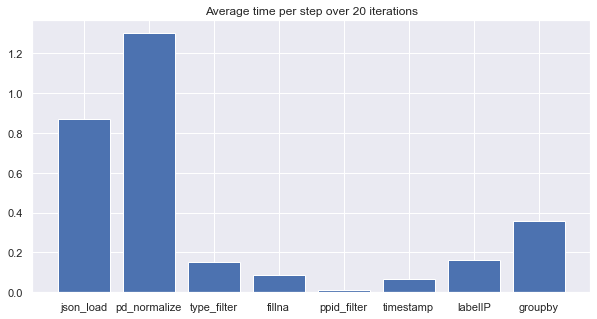

In [160]:
avg_ticks = np.diff(np.array(global_checks), axis=1).mean(axis=0)

# barplot avg_ticks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5))
steps = ['json_load', 'pd_normalize', 'type_filter', 'fillna', 'ppid_filter', 'timestamp', 'labelIP', 'groupby']
ax = plt.bar(x=steps, height=avg_ticks)
plt.title(f"Average time per step over {LIMIT} iterations")

In [161]:
avg_ticks[6]

0.16423373222351073

### Times

IP labeling with `np.where` and `str.match` == `0.142` s (excluding private ranges) over 20 iterations  
IP labeling with `np.where` and `str.match` == `0.164` s (including private ranges) over 20 iterations


# Making reading JSON faster?

In [170]:
cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ]
def filter_dict_with_keys(dict, key_list):
    return {k: dict[k] for k in key_list if k in dict}

_ = [filter_dict_with_keys(x, cols) for x in data]

0, took: 2.21s; 1, took: 2.38s; 2, took: 2.67s; 3, took: 2.08s; 4, took: 2.26s; 5, took: 2.55s; 6, took: 1.97s; 7, took: 2.60s; 8, took: 2.36s; 9, took: 2.47s; 10, took: 2.46s; 11, took: 2.27s; 12, took: 1.89s; 13, took: 2.07s; 14, took: 1.78s; 15, took: 2.03s; 16, took: 1.82s; 17, took: 2.02s; 18, took: 1.92s; 19, took: 2.12s; 

Text(0.5, 1.0, 'Average time per step over 20 iterations')

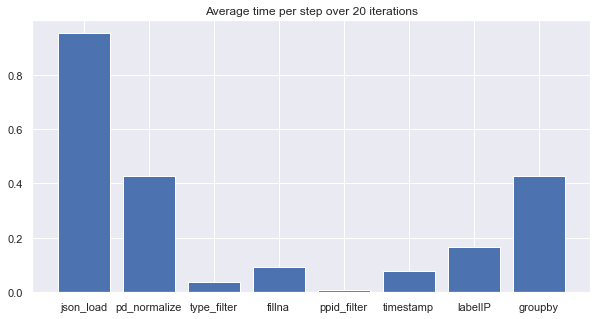

In [171]:
def labelIPAddresses(ldf):
    col = 'auditd.summary.object.primary'
    ldf[col] = np.where(ldf[col].str.startswith('127.'), "(lopIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match('169.254.169.254'), "(imds)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'), "(prvIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'), "(pubIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^([0-9a-fA-F]{1,4}:){1,7}:'), "(IPv6)", ldf[col])
    return ldf


def filter_dict_with_keys(dict, key_list):
    return {k: dict[k] for k in key_list if k in dict}


def preprocessAuditdTable(df,
    sids = [
    'execution',
    'mount',
    'external-access',
    'log-modification',
    'user_start',
    'user_end',
    'bind-access',
    'time-change',
    'perm_modification',
    'inbound-access',
    'unsucces_file_access'
    ]
):
    """
    input is a dataframe with 5min of data
    output is a string with data in fastText format
    """
    checks = []
    # filter only necessary event types and columns
    newdf = df[df['rule.sidid'].isin(sids)].copy()
    del df

    checks.append(time.time())
    # dealing with NaN to avoid errors
    newdf.fillna("(none)", inplace=True)

    checks.append(time.time())
    ## ppid preprocessing
    newdf['process.ppid'] = newdf['process.ppid'].apply(lambda x: x if x == "1" else "(pid)")

    checks.append(time.time())
    # timestamping
    newdf['TimeStamp'] = pd.to_datetime(newdf.TimeStamp)
    newdf.sort_values(by=['TimeStamp'], inplace=True)

    checks.append(time.time())
    #newdf = newdf.apply(labelIPAddresses, axis=1)
    newdf = labelIPAddresses(newdf)

    checks.append(time.time())
    out = []
    for _, groupDf in newdf.groupby('hostname'):
    
        # adds this as last column
        groupDf['event.separator'] = "(sep)"

        # CONSIDER:
        # my data has been already divided to 5min chunks
        # it might be needed to do chunking here based on TimeStamp if not done

        arr = groupDf.drop(['TimeStamp', 'hostname'], axis=1).values

        # fastText expects whitespace separated values in utf-8
        # can't use spaces since are present in process.title, so use \t
        host_telemetry = ", ".join(arr.flatten()).encode().decode('utf-8', 'ignore') 
        out.append(host_telemetry)
    checks.append(time.time())

    return out, checks

FOLDER = "../../data/auditd_raw/"
LIMIT = 20
files = os.listdir(FOLDER)[:LIMIT]

cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ]

global_checks = []
for i,file in enumerate(files):
    c1 = time.time()
    data = json.load(open(FOLDER+file, "r"))[:-1]
    c2 = time.time()
    data_filtered = [filter_dict_with_keys(x, cols) for x in data]
    ldf = pd.json_normalize(data_filtered)
    c3 = time.time()
    
    out, checks = preprocessAuditdTable(ldf)
    
    global_checks.append([c1,c2,c3] + checks)
    print(f"{i}, took: {time.time()-c1:.2f}s", end="; ")

avg_ticks = np.diff(np.array(global_checks), axis=1).mean(axis=0)

# barplot avg_ticks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5))
steps = ['json_load', 'pd_normalize', 'type_filter', 'fillna', 'ppid_filter', 'timestamp', 'labelIP', 'groupby']
ax = plt.bar(x=steps, height=avg_ticks)
plt.title(f"Average time per step over {LIMIT} iterations")

# Trying to speed up `json.load` with `orjson`

0, took: 1.45s; 1, took: 1.25s; 2, took: 1.49s; 3, took: 1.24s; 4, took: 1.33s; 5, took: 1.50s; 6, took: 1.23s; 7, took: 1.54s; 8, took: 1.45s; 9, took: 1.81s; 10, took: 1.66s; 11, took: 1.54s; 12, took: 1.29s; 13, took: 1.29s; 14, took: 1.28s; 15, took: 1.45s; 16, took: 1.24s; 17, took: 1.38s; 18, took: 1.31s; 19, took: 1.29s; Avg time: 1.40s


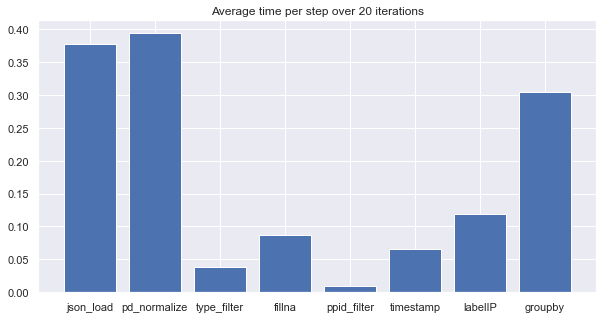

In [194]:
import orjson
import pandas as pd

def labelIPAddresses(ldf):
    col = 'auditd.summary.object.primary'
    ldf[col] = np.where(ldf[col].str.startswith('127.'), "(lopIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match('169.254.169.254'), "(imds)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'), "(prvIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'), "(pubIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^([0-9a-fA-F]{1,4}:){1,7}:'), "(IPv6)", ldf[col])
    return ldf


def filter_dict_with_keys(dict, key_list):
    return {k: dict[k] for k in key_list if k in dict}


def preprocessAuditdTable(df,
    sids = [
    'execution',
    'mount',
    'external-access',
    'log-modification',
    'user_start',
    'user_end',
    'bind-access',
    'time-change',
    'perm_modification',
    'inbound-access',
    'unsucces_file_access'
    ]
):
    """
    input is a dataframe with 5min of data
    output is a string with data in fastText format
    """
    checks = []
    # filter only necessary event types and columns
    newdf = df[df['rule.sidid'].isin(sids)].copy()
    del df

    checks.append(time.time())
    # dealing with NaN to avoid errors
    newdf.fillna("(none)", inplace=True)

    checks.append(time.time())
    ## ppid preprocessing
    newdf['process.ppid'] = newdf['process.ppid'].apply(lambda x: x if x == "1" else "(pid)")

    checks.append(time.time())
    # timestamping
    newdf['TimeStamp'] = pd.to_datetime(newdf.TimeStamp)
    newdf.sort_values(by=['TimeStamp'], inplace=True)

    checks.append(time.time())
    #newdf = newdf.apply(labelIPAddresses, axis=1)
    newdf = labelIPAddresses(newdf)

    checks.append(time.time())
    out = []
    for _, groupDf in newdf.groupby('hostname'):
    
        # adds this as last column
        groupDf['event.separator'] = "(sep)"

        # CONSIDER:
        # my data has been already divided to 5min chunks
        # it might be needed to do chunking here based on TimeStamp if not done

        arr = groupDf.drop(['TimeStamp', 'hostname'], axis=1).values

        # fastText expects whitespace separated values in utf-8
        # can't use spaces since are present in process.title, so use \t
        host_telemetry = ", ".join(arr.flatten()).encode().decode('utf-8', 'ignore') 
        out.append(host_telemetry)
    checks.append(time.time())

    return out, checks

FOLDER = "../../data/auditd_raw/"
LIMIT = 20
files = os.listdir(FOLDER)[:LIMIT]

cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ]

global_checks = []
ticks = []
for i,file in enumerate(files):
    c1 = time.time()
    #data = json.load(open(FOLDER+file, "r"))[:-1]
    with open(FOLDER+file, "rb") as f:
        data = orjson.loads(f.read())[:-1]
    c2 = time.time()
    data_filtered = [filter_dict_with_keys(x, cols) for x in data]
    ldf = pd.json_normalize(data_filtered)[cols]
    c3 = time.time()
    
    out, checks = preprocessAuditdTable(ldf)
    
    global_checks.append([c1,c2,c3] + checks)
    tick = time.time()-c1
    ticks.append(tick)
    print(f"{i}, took: {tick:.2f}s", end="; ")

avg_ticks = np.diff(np.array(global_checks), axis=1).mean(axis=0)

# barplot avg_ticks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5))
steps = ['json_load', 'pd_normalize', 'type_filter', 'fillna', 'ppid_filter', 'timestamp', 'labelIP', 'groupby']
ax = plt.bar(x=steps, height=avg_ticks)
plt.title(f"Average time per step over {LIMIT} iterations")
print(f"Avg time: {sum(ticks)/len(ticks):.2f}s")

0, took: 1.43s; 1, took: 1.25s; 2, took: 1.39s; 3, took: 1.30s; 4, took: 1.34s; 5, took: 1.45s; 6, took: 1.21s; 7, took: 1.33s; 8, took: 1.20s; 9, took: 1.24s; 10, took: 1.27s; 11, took: 1.23s; 12, took: 1.16s; 13, took: 1.24s; 14, took: 1.18s; 15, took: 1.24s; 16, took: 1.16s; 17, took: 1.37s; 18, took: 1.35s; 19, took: 1.34s; Avg time: 1.28s


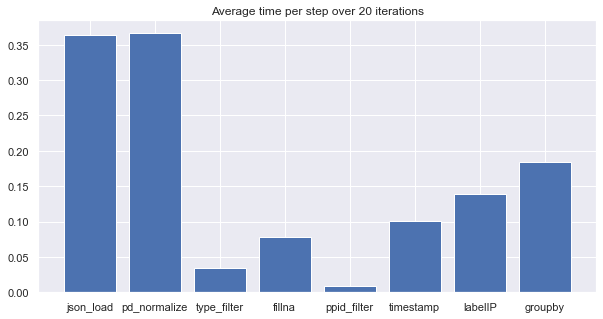

In [195]:
import orjson
import pandas as pd

def labelIPAddresses(ldf):
    col = 'auditd.summary.object.primary'
    ldf[col] = np.where(ldf[col].str.startswith('127.'), "(lopIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match('169.254.169.254'), "(imds)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'(^10\.)|(^172\.1[6-9]\.)|(^172\.2[0-9]\.)|(^172\.3[0-1]\.)|(^192\.168\.)'), "(prvIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}\.[0-9]{1,3}$'), "(pubIP)", ldf[col])
    ldf[col] = np.where(ldf[col].str.match(r'^([0-9a-fA-F]{1,4}:){1,7}:'), "(IPv6)", ldf[col])
    return ldf


def filter_dict_with_keys(dict, key_list):
    return {k: dict[k] for k in key_list if k in dict}


def preprocessAuditdTable(df,
    sids = [
    'execution',
    'mount',
    'external-access',
    'log-modification',
    'user_start',
    'user_end',
    'bind-access',
    'time-change',
    'perm_modification',
    'inbound-access',
    'unsucces_file_access'
    ]
):
    """
    input is a dataframe with 5min of data
    output is a string with data in fastText format
    """
    checks = []
    # filter only necessary event types and columns
    newdf = df[df['rule.sidid'].isin(sids)].copy()
    del df

    checks.append(time.time())
    # dealing with NaN to avoid errors
    newdf.fillna("(none)", inplace=True)

    checks.append(time.time())
    ## ppid preprocessing
    newdf['process.ppid'] = newdf['process.ppid'].apply(lambda x: x if x == "1" else "(pid)")

    checks.append(time.time())
    # timestamping
    newdf['TimeStamp'] = pd.to_datetime(newdf.TimeStamp)
    newdf.sort_values(by=['TimeStamp'], inplace=True)
    newdf.drop(columns=['TimeStamp'], inplace=True) # takes ~0.03s

    checks.append(time.time())
    #newdf = newdf.apply(labelIPAddresses, axis=1)
    newdf = labelIPAddresses(newdf)
    
    # adds this as last column
    newdf['event.separator'] = "(sep)"


    checks.append(time.time())
    out = []
    for _, groupDf in newdf.groupby('hostname'):
        arr = groupDf.drop(columns=['hostname']).values.flatten()
        # fastText expects whitespace separated values in utf-8
        # I additionally introduce ',' since process.title has spaces
        host_telemetry = ", ".join(arr).encode().decode('utf-8', 'ignore') 
        out.append(host_telemetry)
    checks.append(time.time())

    return out, checks

FOLDER = "../../data/auditd_raw/"
LIMIT = 20
files = os.listdir(FOLDER)[:LIMIT]

cols = [
        'TimeStamp',
        'rule.sidid',
        'hostname',
        'auditd.data.syscall',
        'auditd.summary.actor.primary',
        'auditd.summary.actor.secondary',
        'auditd.summary.object.primary',
        'auditd.summary.object.secondary',
        'process.title',
        'process.working_directory',
        'process.ppid',
        'process.parent.process.executable',
        'process.parent.process.title'
    ]

global_checks = []
ticks = []
for i,file in enumerate(files):
    c1 = time.time()
    #data = json.load(open(FOLDER+file, "r"))[:-1]
    with open(FOLDER+file, "rb") as f:
        data = orjson.loads(f.read())[:-1]
    c2 = time.time()
    data_filtered = [filter_dict_with_keys(x, cols) for x in data]
    ldf = pd.json_normalize(data_filtered)[cols]
    c3 = time.time()
    
    out, checks = preprocessAuditdTable(ldf)
    
    global_checks.append([c1,c2,c3] + checks)
    tick = time.time()-c1
    ticks.append(tick)
    print(f"{i}, took: {tick:.2f}s", end="; ")

avg_ticks = np.diff(np.array(global_checks), axis=1).mean(axis=0)

# barplot avg_ticks
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(10,5))
steps = ['json_load', 'pd_normalize', 'type_filter', 'fillna', 'ppid_filter', 'timestamp', 'labelIP', 'groupby']
ax = plt.bar(x=steps, height=avg_ticks)
_ = plt.title(f"Average time per step over {LIMIT} iterations")
print(f"Avg time: {sum(ticks)/len(ticks):.2f}s")

In [197]:
ldf.head()

TimeStamp rule.sidid     hostname auditd.data.syscall  \
0  2022-09-12T06:22:52.9660000Z  execution  ed10-o365ip              execve   
1  2022-09-12T06:22:53.2660000Z  execution  ed10-o365ip              execve   
2  2022-09-12T06:22:53.2700000Z  execution  ed10-o365ip              execve   
3  2022-09-12T06:22:53.5660000Z  execution  ed10-o365ip              execve   
4  2022-09-12T06:22:53.7060000Z  execution  ed10-o365ip              execve   

  auditd.summary.actor.primary auditd.summary.actor.secondary  \
0                        unset                           root   
1                        unset                           root   
2                        unset                           root   
3                        unset                           root   
4                        unset                           root   

  auditd.summary.object.primary auditd.summary.object.secondary  \
0                    /bin/uname                             NaN   
1                /sbin/iptables                             NaN   
2                /sbin/iptables                             NaN   
3            /usr/bin/python2.7                             NaN   
4                       /bin/sh                             NaN   

                                       process.title  \
0                                           uname -p   
1  /usr/bin/python3 -u /usr/sbin/waagent -run-ext...   
2  /usr/bin/python3 -u /usr/sbin/waagent -run-ext...   
3  /usr/bin/python2.7 /var/lib/ambari-agent/cache...   
4                        sh -c uname -p 2> /dev/null   

  process.working_directory process.ppid process.parent.process.executable  \
0                         /        28974                                     
1                         /         3010                /usr/bin/python3.5   
2                         /         3010                /usr/bin/python3.5   
3                         /         6685                /usr/bin/python2.7   
4                         /        28979                /usr/bin/python2.7   

                        process.parent.process.title  
0                                                     
1  /usr/bin/python3 -u /usr/sbin/waagent -run-ext...  
2  /usr/bin/python3 -u /usr/sbin/waagent -run-ext...  
3  /usr/bin/python2.7 /usr/lib/ambari-agent/lib/a...  
4  /usr/bin/python2.7 /var/lib/ambari-agent/cache...

In [196]:
out

['external-access, connect, unset, 102, (pubIP), 443, /usr/sbin/mdsd -A -c /etc/mdsd.d/mdsd.xml -r /var/run/mdsd/default -S /var/opt/microsoft/linuxmonagent/eh -e /var/log/mdsd.err -, (none), 1, (none), (none), (sep), external-access, connect, unset, 102, (pubIP), 443, /usr/sbin/mdsd -A -c /etc/mdsd.d/mdsd.xml -r /var/run/mdsd/default -S /var/opt/microsoft/linuxmonagent/eh -e /var/log/mdsd.err -, (none), 1, (none), (none), (sep), external-access, connect, unset, 102, (pubIP), 443, /usr/sbin/mdsd -A -c /etc/mdsd.d/mdsd.xml -r /var/run/mdsd/default -S /var/opt/microsoft/linuxmonagent/eh -e /var/log/mdsd.err -, (none), 1, (none), (none), (sep), external-access, connect, unset, 102, (pubIP), 443, /usr/sbin/mdsd -A -c /etc/mdsd.d/mdsd.xml -r /var/run/mdsd/default -S /var/opt/microsoft/linuxmonagent/eh -e /var/log/mdsd.err -, (none), 1, (none), (none), (sep), external-access, connect, unset, 102, (pubIP), 443, /usr/sbin/mdsd -A -c /etc/mdsd.d/mdsd.xml -r /var/run/mdsd/default -S /var/opt/mic